# Unsupervised Learning Section

Import Statements

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import VarianceThreshold


Loading in data from Kaggle

In [2]:
offense_df = pd.read_csv("Kaggle NFL CSVs/weekly_team_stats_offense.csv")
defense_df = pd.read_csv("Kaggle NFL CSVs/weekly_team_stats_defense.csv")
group_cols = ['season','team','season_type']
offense_team_df = offense_df.groupby(group_cols).sum(numeric_only=True).reset_index()
defense_team_df = defense_df.groupby(group_cols).sum(numeric_only=True).reset_index()
team_df_merged = pd.merge(offense_team_df, defense_team_df, on=group_cols, suffixes=('_off', '_def'))

#in team_df each row is one team in one season

Displaying all columns in the df for reference:

In [3]:
for col in team_df_merged.columns:
    print(col)

season
team
season_type
week_off
shotgun
no_huddle
qb_dropback
qb_scramble
total_off_yards
pass_attempts
complete_pass
incomplete_pass
passing_yards
air_yards
receiving_yards
yards_after_catch
rush_attempts
rushing_yards
tackled_for_loss
first_down_pass
first_down_rush
third_down_converted
third_down_failed
fourth_down_converted
fourth_down_failed
rush_touchdown
pass_touchdown
safety_off
interception_off
fumble_off
fumble_lost_off
fumble_forced_off
fumble_not_forced_off
fumble_out_of_bounds_off
total_off_points_off
total_def_points_off
extra_point_off
field_goal_off
kickoff_off
no_play_off
pass_snaps_off
punt_off
qb_kneel_off
qb_spike_off
rush_snaps_off
offense_snaps
st_snaps_off
rush_pct_off
pass_pct_off
home_win_off
home_loss_off
home_tie_off
away_win_off
away_loss_off
away_tie_off
win_off
loss_off
tie_off
win_pct_off
passing_air_yards
receiving_air_yards
receptions
receiving_touchdown
targets
yps
adot
air_yards_share
target_share
comp_pct
int_pct
pass_td_pct
ypa
rec_td_pct
yptarget


In [4]:
#Data-preprocessing steps
#Rows and columns of team_df after merging
print(team_df_merged.shape) 
#Checked for any missing values as K-means clustering does not work will with missing values 
pd.set_option('display.max_columns', None)
null_counts = team_df_merged.isnull().sum()
print(null_counts[null_counts > 0])
#Describe the dataset
#print(team_df_merged.describe()) 
#print(team_df_merged.dtypes)
#Remove columns that contain all 0's, as those columns have no variance and K-Means relies on distance calculations
#Drop columns in team_df that contain all zeros
all_zero_cols = team_df_merged.columns[(team_df_merged == 0).all()]
print("Columns with all zeros removed:", list(all_zero_cols))
# Drop them from team_df_merged
team_revised_df = team_df_merged.drop(columns=all_zero_cols)
for col in team_revised_df.columns:
    print(f"{col}: {team_revised_df[col].dtype}")
print(team_revised_df.shape)  # Fixed the error by removing parentheses
#Drop all non-numeric columns : season (even though defined as an int contains just the years), team, and season_type
features = team_revised_df.drop(columns=['season', 'team', 'season_type'], errors='ignore')
#print(features.shape)  # Fixed the error by removing parentheses
print(features.describe())

(582, 173)
Series([], dtype: int64)
Columns with all zeros removed: ['home_tie_off', 'away_tie_off', 'tie_off', 'defensive_extra_point_attempt', 'defensive_extra_point_conv', 'home_tie_def', 'away_tie_def', 'tie_def', 'average_defensive_extra_point_attempt', 'average_defensive_extra_point_conv']
season: int64
team: object
season_type: object
week_off: int64
shotgun: int64
no_huddle: int64
qb_dropback: int64
qb_scramble: int64
total_off_yards: int64
pass_attempts: int64
complete_pass: int64
incomplete_pass: int64
passing_yards: int64
air_yards: int64
receiving_yards: int64
yards_after_catch: int64
rush_attempts: int64
rushing_yards: int64
tackled_for_loss: int64
first_down_pass: int64
first_down_rush: int64
third_down_converted: int64
third_down_failed: int64
fourth_down_converted: int64
fourth_down_failed: int64
rush_touchdown: int64
pass_touchdown: int64
safety_off: int64
interception_off: int64
fumble_off: int64
fumble_lost_off: int64
fumble_forced_off: int64
fumble_not_forced_off: i

For unsupervised learning, we decided to use K-Means Clustering. We wanted to use team-season & season_type level data to cluster teams based on their playing styles. In this case, there are two season types: REG and POST. REG refers to the regular season and POST refers to playoffs

Displaying all columns in dataframe after pre-processing is done 

In [5]:
for col in features.columns:
    print(col)

week_off
shotgun
no_huddle
qb_dropback
qb_scramble
total_off_yards
pass_attempts
complete_pass
incomplete_pass
passing_yards
air_yards
receiving_yards
yards_after_catch
rush_attempts
rushing_yards
tackled_for_loss
first_down_pass
first_down_rush
third_down_converted
third_down_failed
fourth_down_converted
fourth_down_failed
rush_touchdown
pass_touchdown
safety_off
interception_off
fumble_off
fumble_lost_off
fumble_forced_off
fumble_not_forced_off
fumble_out_of_bounds_off
total_off_points_off
total_def_points_off
extra_point_off
field_goal_off
kickoff_off
no_play_off
pass_snaps_off
punt_off
qb_kneel_off
qb_spike_off
rush_snaps_off
offense_snaps
st_snaps_off
rush_pct_off
pass_pct_off
home_win_off
home_loss_off
away_win_off
away_loss_off
win_off
loss_off
win_pct_off
passing_air_yards
receiving_air_yards
receptions
receiving_touchdown
targets
yps
adot
air_yards_share
target_share
comp_pct
int_pct
pass_td_pct
ypa
rec_td_pct
yptarget
ayptarget
ypr
rush_td_pct
ypc
touches
total_tds
td_pct
tot

Feature Selection - Used domain knowledge to select the features that help answer the following research questions

Using all of the 160 columns would not make sense in this case as it adds noise and decreases clustering effectiveness. Through this unsupervised learning exercise, we want to answer the following questions:

1) What distinct categories of team performance exist? (Underperforming, balanced, elite)

2) What are typical characteristics of teams in each cluster? (Offensive - heavy teams v.s. Defensive heavy teams)

3) How do offensive-heavy teams compare to defensive-heavy teams in terms of win %?

In [6]:
selected_features = [
    'total_off_yards', 'pass_attempts', 'rushing_yards',
    'pass_touchdown', 'rush_touchdown',
    'sack', 'interception_def', 'solo_tackle', 'assist_tackle',
    'def_touchdown', 'win_pct_off', 'win_pct_def'
]
features_domain_selected = features[selected_features]
print(features_domain_selected)
print(features_domain_selected.head())
selector = VarianceThreshold(threshold=0.01)
selector.fit(features_domain_selected)
feature_mask = selector.get_support()
remaining_features = features_domain_selected.columns[feature_mask]
print("Remaining features after low variance filtering:")
print(list(remaining_features))
# Get list of dropped low-variance features
dropped_features = features_domain_selected.columns[~feature_mask]
print("Features dropped due to low variance:")
print(list(dropped_features))

# Optionally create a reduced features dataframe
features_reduced = features_domain_selected[remaining_features]
print(features_reduced)

     total_off_yards  pass_attempts  rushing_yards  pass_touchdown  \
0               4587            587           1204              11   
1                894             74            248               6   
2               6116            601           1397              32   
3               1679            126            539              11   
4               5897            549           1901              22   
..               ...            ...            ...             ...   
577              286             18            101               2   
578             7041            555           2536              41   
579             5476            509           1855              22   
580             1208            114            363               5   
581             6550            516           2618              29   

     rush_touchdown  sack  interception_def  solo_tackle  assist_tackle  \
0                10    38                22          731            120   
1        

Performed the low variance check to ensure that any features we selected do not have low variance. This is important for K-Means because K-means clustering uses Euclidean distance to assign points to clusters. Low variance features add noise and they contribute no meaningful variation to help define clusters. 

Standard scaler and Elbow Method to identify optimal amount of clusters

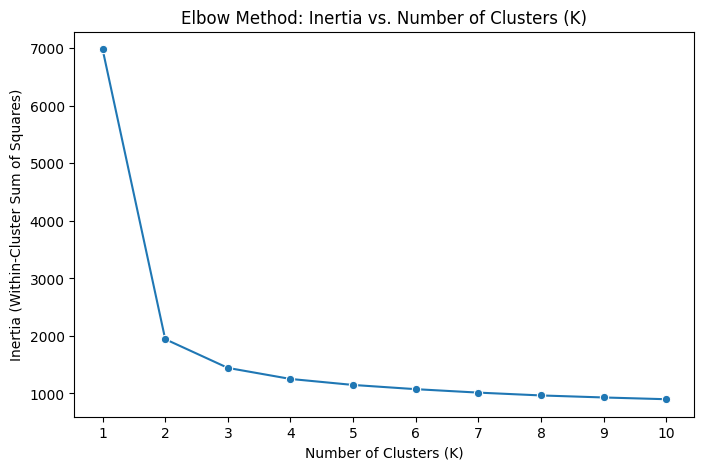

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_reduced)
#Elbow Method
K_range = range(1, 11)
inertia = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(8,5))
sns.lineplot(x=K_range, y=inertia, marker='o')
plt.title('Elbow Method: Inertia vs. Number of Clusters (K)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.xticks(K_range)
plt.show()

By utilizing the elbow method to identify the optimal amount of clusters k, we can come to the conclusion that k = 3. K=3 appears to be that point because that is where plot starts to flatten, indicating that adding more clusters will yield to diminishing returns. 

In [8]:
optimal_k = 3
#We have defined random_state = 42 so that we get the same results each time we run the code
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
#Computing the Silhoutte Score 
score = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score for K=3: {score:.4f}")

Silhouette Score for K=3: 0.4061


Silhouette Score of 0.4061 indicates the clusters are meanigful with some overlap and there is a resonable clustering structure. 

In [9]:
#Assign clusters to dataframe and helps us identify what clusters the teams belong to 
team_df_merged['clusters'] = clusters
#print(team_df_merged)
#From this analysis, we can figure out that 166 teams belong to cluster 0, 214 teams belong to cluster 1, and 202 teams belong to cluster 2
print(team_df_merged['clusters'].value_counts().sort_index())
key_stats = [
    'total_off_yards', 'pass_attempts', 'rushing_yards',
    'sack', 'interception_def', 'win_pct_off', 'win_pct_def'
]
available_cols = [col for col in team_df_merged.columns if col in key_stats]
cluster_means = team_df_merged.groupby('clusters')[available_cols].mean()
print("\nMean stats per cluster:")
print(cluster_means)

clusters
0    166
1    214
2    202
Name: count, dtype: int64

Mean stats per cluster:
          total_off_yards  pass_attempts  rushing_yards  win_pct_off  \
clusters                                                               
0              686.018072      63.939759     211.548193     1.282795   
1             5684.107477     554.046729    1752.191589     5.617963   
2             6103.420792     545.366337    1974.821782    10.851470   

          interception_def       sack  win_pct_def  
clusters                                            
0                 1.427711   4.283133     1.282795  
1                11.462617  36.116822     5.617963  
2                15.579208  41.608911    10.851470  


From this table, we can easily identify that Cluster 0 contains of underperforming teams, cluster 1 contains of average/mediocre teams that are not elite, and cluster 2 contains of eliteCluster 0 is weak in both offense and defense. Cluster 1 consists of teams with moderate performance, with standout strenghts, and cluster 2 contains of teams with strong offensive


Teams in each cluster:
Cluster 0: ['ATL', 'BAL', 'CIN', 'DEN', 'GB', 'HOU', 'IND', 'MIN', 'NE', 'SEA', 'SF', 'WAS', 'CAR', 'KC', 'LAC', 'NO', 'PHI', 'ARI', 'DAL', 'DET', 'PIT', 'LV', 'MIA', 'NYG', 'BUF', 'JAX', 'LA', 'TEN', 'CHI', 'CLE', 'TB']
Cluster 1: ['BUF', 'CAR', 'CLE', 'DAL', 'DET', 'JAX', 'KC', 'LV', 'MIA', 'NO', 'NYJ', 'PHI', 'PIT', 'TEN', 'ATL', 'BAL', 'GB', 'HOU', 'LAC', 'MIN', 'NYG', 'TB', 'WAS', 'CHI', 'LA', 'SF', 'ARI', 'CIN', 'IND', 'DEN', 'NE', 'SEA']
Cluster 2: ['ARI', 'ATL', 'BAL', 'CHI', 'CIN', 'DEN', 'GB', 'HOU', 'IND', 'LA', 'LAC', 'MIN', 'NE', 'NYG', 'SEA', 'SF', 'TB', 'WAS', 'CAR', 'DAL', 'DET', 'KC', 'MIA', 'NO', 'PHI', 'TEN', 'BUF', 'CLE', 'PIT', 'NYJ', 'LV', 'JAX']


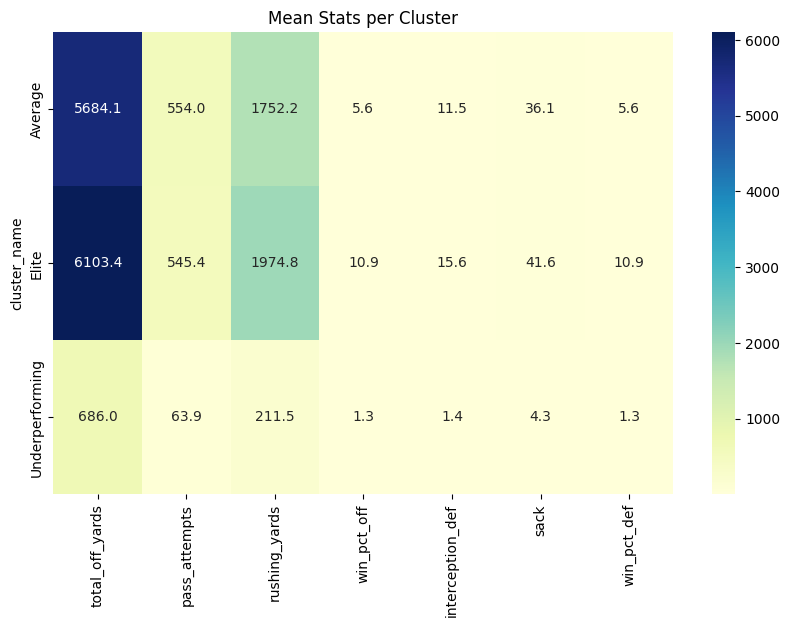

In [10]:
teams_in_clusters = team_df_merged.groupby('clusters')['team'].unique()
print("\nTeams in each cluster:")
for cluster, teams in teams_in_clusters.items():
    print(f"Cluster {cluster}: {list(teams)}")
cluster_names = {
    0: "Underperforming",
    1: "Average",
    2: "Elite"
}

team_df_merged['cluster_name'] = team_df_merged['clusters'].map(cluster_names)
heatmap_data = team_df_merged.groupby('cluster_name')[available_cols].mean()

plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Mean Stats per Cluster")
plt.show()

Looking at teams-season-season type in each cluster to assess how the team specifically grew in terms of performance. 

In [11]:
teams_in_clusters = team_df_merged.groupby('clusters')[["season", "team", "season_type"]]


print("\nTeams in each cluster:")
for cluster, teams in teams_in_clusters:
    cluster_lst = []
    for team_idx in range(len(teams)):
        team = teams.iloc[team_idx]
        cluster_lst.append((team["season"], team["team"], team["season_type"]))
    print(f"Cluster {cluster}: {cluster_lst}")


Teams in each cluster:
Cluster 0: [(2012, 'ATL', 'POST'), (2012, 'BAL', 'POST'), (2012, 'CIN', 'POST'), (2012, 'DEN', 'POST'), (2012, 'GB', 'POST'), (2012, 'HOU', 'POST'), (2012, 'IND', 'POST'), (2012, 'MIN', 'POST'), (2012, 'NE', 'POST'), (2012, 'SEA', 'POST'), (2012, 'SF', 'POST'), (2012, 'WAS', 'POST'), (2013, 'CAR', 'POST'), (2013, 'CIN', 'POST'), (2013, 'DEN', 'POST'), (2013, 'GB', 'POST'), (2013, 'IND', 'POST'), (2013, 'KC', 'POST'), (2013, 'LAC', 'POST'), (2013, 'NE', 'POST'), (2013, 'NO', 'POST'), (2013, 'PHI', 'POST'), (2013, 'SEA', 'POST'), (2013, 'SF', 'POST'), (2014, 'ARI', 'POST'), (2014, 'BAL', 'POST'), (2014, 'CAR', 'POST'), (2014, 'CIN', 'POST'), (2014, 'DAL', 'POST'), (2014, 'DEN', 'POST'), (2014, 'DET', 'POST'), (2014, 'GB', 'POST'), (2014, 'IND', 'POST'), (2014, 'NE', 'POST'), (2014, 'PIT', 'POST'), (2014, 'SEA', 'POST'), (2015, 'ARI', 'POST'), (2015, 'CAR', 'POST'), (2015, 'CIN', 'POST'), (2015, 'DEN', 'POST'), (2015, 'GB', 'POST'), (2015, 'HOU', 'POST'), (2015, 'K

In [15]:
#Sensitivity Analysis - How does the changing the values of K affect the clustering results and silhouette score?
optimal_k = 2
#We have defined random_state = 42 so that we get the same results each time we run the code
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
#Computing the Silhoutte Score 
score = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score for K=2: {score:.4f}")

optimal_k = 4
#We have defined random_state = 42 so that we get the same results each time we run the code
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
#Computing the Silhoutte Score 
score = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score for K=4: {score:.4f}")

Silhouette Score for K=2: 0.6603
Silhouette Score for K=4: 0.3919


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=32f663d2-ff71-4fff-a76e-068fa019f967' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>